In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, LinearConstraint, OptimizeResult
import matplotlib.pyplot as plt
import math

In [2]:
class Simulated(object):
    time_step = None
    g = 9.81

In [3]:
class Car(Simulated):
    """ This class represents a car moving in 1D, subject to a throttle force F, with mass m,
        aerodynamic drag coefficient b, F_max/F_min forces, and time step T.
    """
    m = 2140                         # Mass of the car
    f = 0.1                          # Friction coefficient
    b = 0.33                         # Aerodynamic drag coefficient
    vF_map = ((0,72),(22000,1710))   # lookup table: Max force applied by the powertrain depends on the speed
    v_max = 45                       # Max speed (m/s)

    def __init__(self):
        self.v = 0  # Speed of the car
        
    def Step(self, command, sin_theta):

        """ Update the speed of the car based on the throttle command [%] and the slope angle theta
        """
        F = command/100 * np.interp(self.v, *self.vF_map)

        # Calculate the derivative dv/dt using the input force and the car's speed and properties
        dv_dt = (F - self.f * self.m - self.b * self.v * self.v - self.g * self.m * sin_theta) / self.m

        # Update the speed by integrating the derivative using the time step T
        prev_v = self.v
        self.v += dv_dt * self.time_step
        self.v = clip(self.v, -self.v_max, self.v_max)
        
        dv_dt = (self.v - prev_v) / self.time_step
        F_actual = dv_dt * self.m + self.b * self.v * self.v + self.g * self.m * sin_theta
        
        return F_actual,self.v

In [4]:
from dataclasses import dataclass
import typing as t

def clip(val, vmin, vmax):
    if val >= vmax:
        return vmax
    if val <= vmin:
        return vmin
    return val

@dataclass
class PID(Simulated):
    """ This class implements a PID controller.
    """
    Kp:       float  # Proportional gain
    Ki:       float  # Integral gain
    Kd:       float  # Derivative gain
    Kaw:      float  # Anti-windup gain
    T_C:      float  # Time constant for derivative filtering
    cmd_max:  t.Optional[float] = 100  # Maximum command [%]
    cmd_min:  t.Optional[float] = -100 # Minimum command [%]
    max_rate: t.Optional[float] = 500  # Maximum rate of change of the command

    def __post_init__(self, *args):
        self.delta_max = self.max_rate*self.time_step
        self.delta_min = -self.max_rate*self.time_step
        
        self.cols = ('err','integral','deriv','command','command_sat')
        self.history = [self.State()]

    @dataclass
    class State:
        err:         t.Optional[float] = 0
        integral:    t.Optional[float] = 0
        deriv:       t.Optional[float] = 0
        command:     t.Optional[float] = 0
        command_sat: t.Optional[float] = 0
       
    def Step(self, measurement, setpoint):
        """ Execute a step of the PID controller.

        Inputs:
            measurement: current measurement of the process variable
            setpoint: desired value of the process variable
        """

        prev = self.history[-1]
        data = self.State()
        
        # Calculate error
        data.err = setpoint - measurement

        # Update integral term with anti-windup
        data.integral = prev.integral + self.time_step * (self.Ki * data.err + self.Kaw * (prev.command_sat - prev.command))

        # Calculate filtered derivative
        data.deriv = (data.err - prev.err + self.T_C * prev.deriv) / (self.time_step + self.T_C)

        # Calculate command using PID equation
        data.command = self.Kp * data.err + data.integral + self.Kd * data.deriv

        # Saturate command
        command_sat = clip(data.command, self.cmd_min, self.cmd_max)

        # Apply rate limiter
        delta = clip(command_sat - prev.command_sat, self.delta_min, self.delta_max)
        data.command_sat = prev.command_sat + delta

        # Apply rate limiter
        delta = clip(command_sat - prev.command_sat, -self.delta_max, self.delta_max)
        data.command_sat = prev.command_sat + delta

        # Store data in history
        self.history.append(data)
        
        return data.command_sat
    
    def Summary(self):
        return pd.DataFrame(self.history)

In [5]:
class Simulation(Simulated):
    t = None
    
    def cache(time_step, end_time, stp, uphill):
        if Simulation.t is None or (Simulated.time_step, Simulation.end_time) != (time_step,end_time):
            Simulated.time_step, Simulation.end_time   = (time_step,end_time)
            Simulation.t = np.arange(0, end_time, time_step)
            Simulation.stp = None
            Simulation.uphill = None
            
        tlen = len(Simulation.t)
        
        if Simulation.stp is None or Simulation.stp[0] != stp:
            Simulation.stp = stp*np.ones(tlen)

        if Simulation.uphill != uphill:
            Simulation.uphill = uphill
            if not uphill:
                Simulation.sin_theta = np.zeros(tlen)
            else:
                sz = round(tlen/3)
                Simulation.sin_theta = np.concatenate((np.zeros(tlen-2*sz),
                                                       math.sin(10 * math.pi / 180) * np.ones(sz),
                                                       math.sin(20 * math.pi / 180) * np.ones(sz),
                                                      ))
    
    def __init__(self, x, time_step, end_time, uphill, stp=42):
        """ Simulate the PID control of a car with given parameters.

            Returns:
            (t, stp, z, command, theta): arrays of time, setpoints, positions, commands and slope angle
        """
    
        Simulation.cache(time_step, end_time, stp, uphill)
        tlen = len(self.t)
        
        self.v = np.zeros(tlen)
        self.command = np.zeros(tlen)
        self.force = np.zeros(tlen)

        # A PI controller is considered - Kd and T_C are set = 0 - this is based on the knowledge that
        # for this problem a PI is sufficient
        self.Kp, self.Ki, self.Kaw = x
        self.Kd = 0
        self.T_C = 0

        # Initialize PID controller
        self.pid = PID(self.Kp, self.Ki, self.Kd, self.Kaw, self.T_C)

        # Initialize car with given parameters
        self.car = Car()

        # Iterate through time steps
        for idx in range(tlen):
            self.command[idx] = self.pid.Step(self.car.v, self.stp[idx])
            self.force[idx],self.v[idx] = self.car.Step(self.command[idx], self.sin_theta[idx])
            
            
    def dataframe(self):
        data = pd.DataFrame({'uphill':    self.uphill,
                             't':         self.t,
                             'stp':       self.stp,
                             'v':         self.v,
                             'command':   self.command,
                             'force':     self.force,
                             'sin_theta': self.sin_theta})
        data.loc[:, ['Kp','Ki','Kaw']] = (self.Kp, self.Ki, self.Kaw)
        return data


In [6]:
def Cost(x, time_step, end_time, We, Wu, uphill):
    """ Calculate the cost function for a given set of parameters.

        Inputs:
        x: PID parameters [Kp, Ki, Kd, Kaw, T_C]
        We: weight on control error
        Wu: weight on control effort

        Returns:
        cost: scalar value representing the total cost
    """

    # Simulate
    data = Simulation(x, time_step, end_time, uphill)
    # Cost function
    # J = sum((stp[i] - v[i])^2*t[i])*We + sum((command[i+1] - command[i])^2)*Wu + command[0]^2*Wu
    overshoot_rows = data.v > data.stp
    
    cost  = We * np.sum(np.square(data.stp - data.v))
    cost += We * 2.0 * np.sum(np.square(data.stp[overshoot_rows] - data.v[overshoot_rows]))
    cost += Wu * np.sum(np.square(np.diff(data.force)))
    cost += Wu * data.force[0] * data.force[0]

    return cost

In [7]:
def plot_sim_data(grouped, by):

    ## print('ngroups',grouped.ngroups)
    ## rowlength = grouped.ngroups                         # fix up if odd number of groups
    fig, axs = plt.subplots(figsize=(20,25), 
                            nrows=4, ncols=1)#,     # fix as above
                            # gridspec_kw=dict(hspace=0.4)) # Much control of gridspec

    axs = axs.flatten()
    keys = grouped.groups.keys()
    
    ax = axs[0]
    for key in keys:
        data = grouped.get_group(key)
        ax.plot(data.t, data.sin_theta, label=' '.join(('%s=%g'%(k,v) for k,v in zip(by,key))))
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Incline: sin(theta)')
    ax.legend()
    ax.grid()
    
    ax = axs[1]
    for key in keys:
        data = grouped.get_group(key)
        ax.plot(data.t, data.command, label=' '.join(('%s=%g'%(k,v) for k,v in zip(by,key))))
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Throttle Level')
    ax.legend()
    ax.grid()
    
    ax = axs[2]
    for key in keys:
        data = grouped.get_group(key)
        ax.plot(data.t, data.force, label=' '.join(('%s=%g'%(k,v) for k,v in zip(by,key))))
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Force [N]')
    ax.legend()
    ax.grid()
    
    ax = axs[3]
    for key in keys:
        data = grouped.get_group(key)
        ax.plot(data.t, data.v, label=' '.join(('%s=%g'%(k,v) for k,v in zip(by,key))))
    ax.plot(data.t, data.stp, '--', label='setpoint')
    ax.set_xlabel('Time [sec]')
    ax.set_ylabel('Speed [m/s]')
    ax.legend()
    ax.grid()
    
    plt.show()


In [8]:
class Test():
    def __init__(self):
        # -------- Configuration --------

        # Simulation parameters
        self.time_step = 0.1
        self.end_time = 60

        # Car parameters
        Car.m = 2140
        Car.b = 0.33
        Car.f = 0.1
        Car.vF_map = ((0,72),(22000,1710))
        Car.v_max = 45

        self.x_man = [20, 10, 5]
        self.x_opt = [self.x_man, self.x_man]

    def train(self):

        # Optimization weights for cost function
        We = [1, 1]
        Wu = [0.0001, 0.0001]
        uphill = [0, 1]

        # Perform minimization for each couple of We and Wu weights
        for idx in range(0, len(We)):
            bounds = ((0, None), (0, None), (0, None))
            r = minimize(Cost, self.x_opt[idx],
                         args=(self.time_step, self.end_time, We[idx], Wu[idx], uphill[idx]),
                         bounds=bounds)
            self.x_opt[idx] = r.x

            # Print optimization results
            print("We = " + "{:.3g}".format(We[idx]) + " Wu = " + "{:.3g}".format(Wu[idx]) + " Uphill = " + "{:.0g}".format(
                uphill[idx]) + " Kp = " + "{:.3g}".format(r.x[0])
                  + " Ki = " + "{:.3g}".format(r.x[1]) + " Kaw = " + "{:.3g}".format(r.x[2]))
            print("Success: " + str(r.success))
            
        return self

    def test(self):
        # Now test the vehicle with additional weight
        Car.m += 500

        # Run simulation with manual tuning
        sim_data = Simulation(self.x_man, self.time_step, self.end_time, 1).dataframe()

        # Run simulation with optimized parameters
        for idx in range(0, len(self.x_opt)):
            data = Simulation(self.x_opt[idx], self.time_step, self.end_time, 1).dataframe()
            sim_data = pd.concat((sim_data,data))
        
        by = ['uphill', 'Kp', 'Ki', 'Kaw'] #, 'We', 'Wu', 'Kp', 'Ki', 'Kaw', 'uphill'])
        grouped = sim_data.groupby(by)
        plot_sim_data(grouped, by)
        
        return self

We = 1 Wu = 0.0001 Uphill = 0 Kp = 22 Ki = 13.6 Kaw = 10.2
Success: True
We = 1 Wu = 0.0001 Uphill = 1 Kp = 19.5 Ki = 11.3 Kaw = 10.1
Success: True


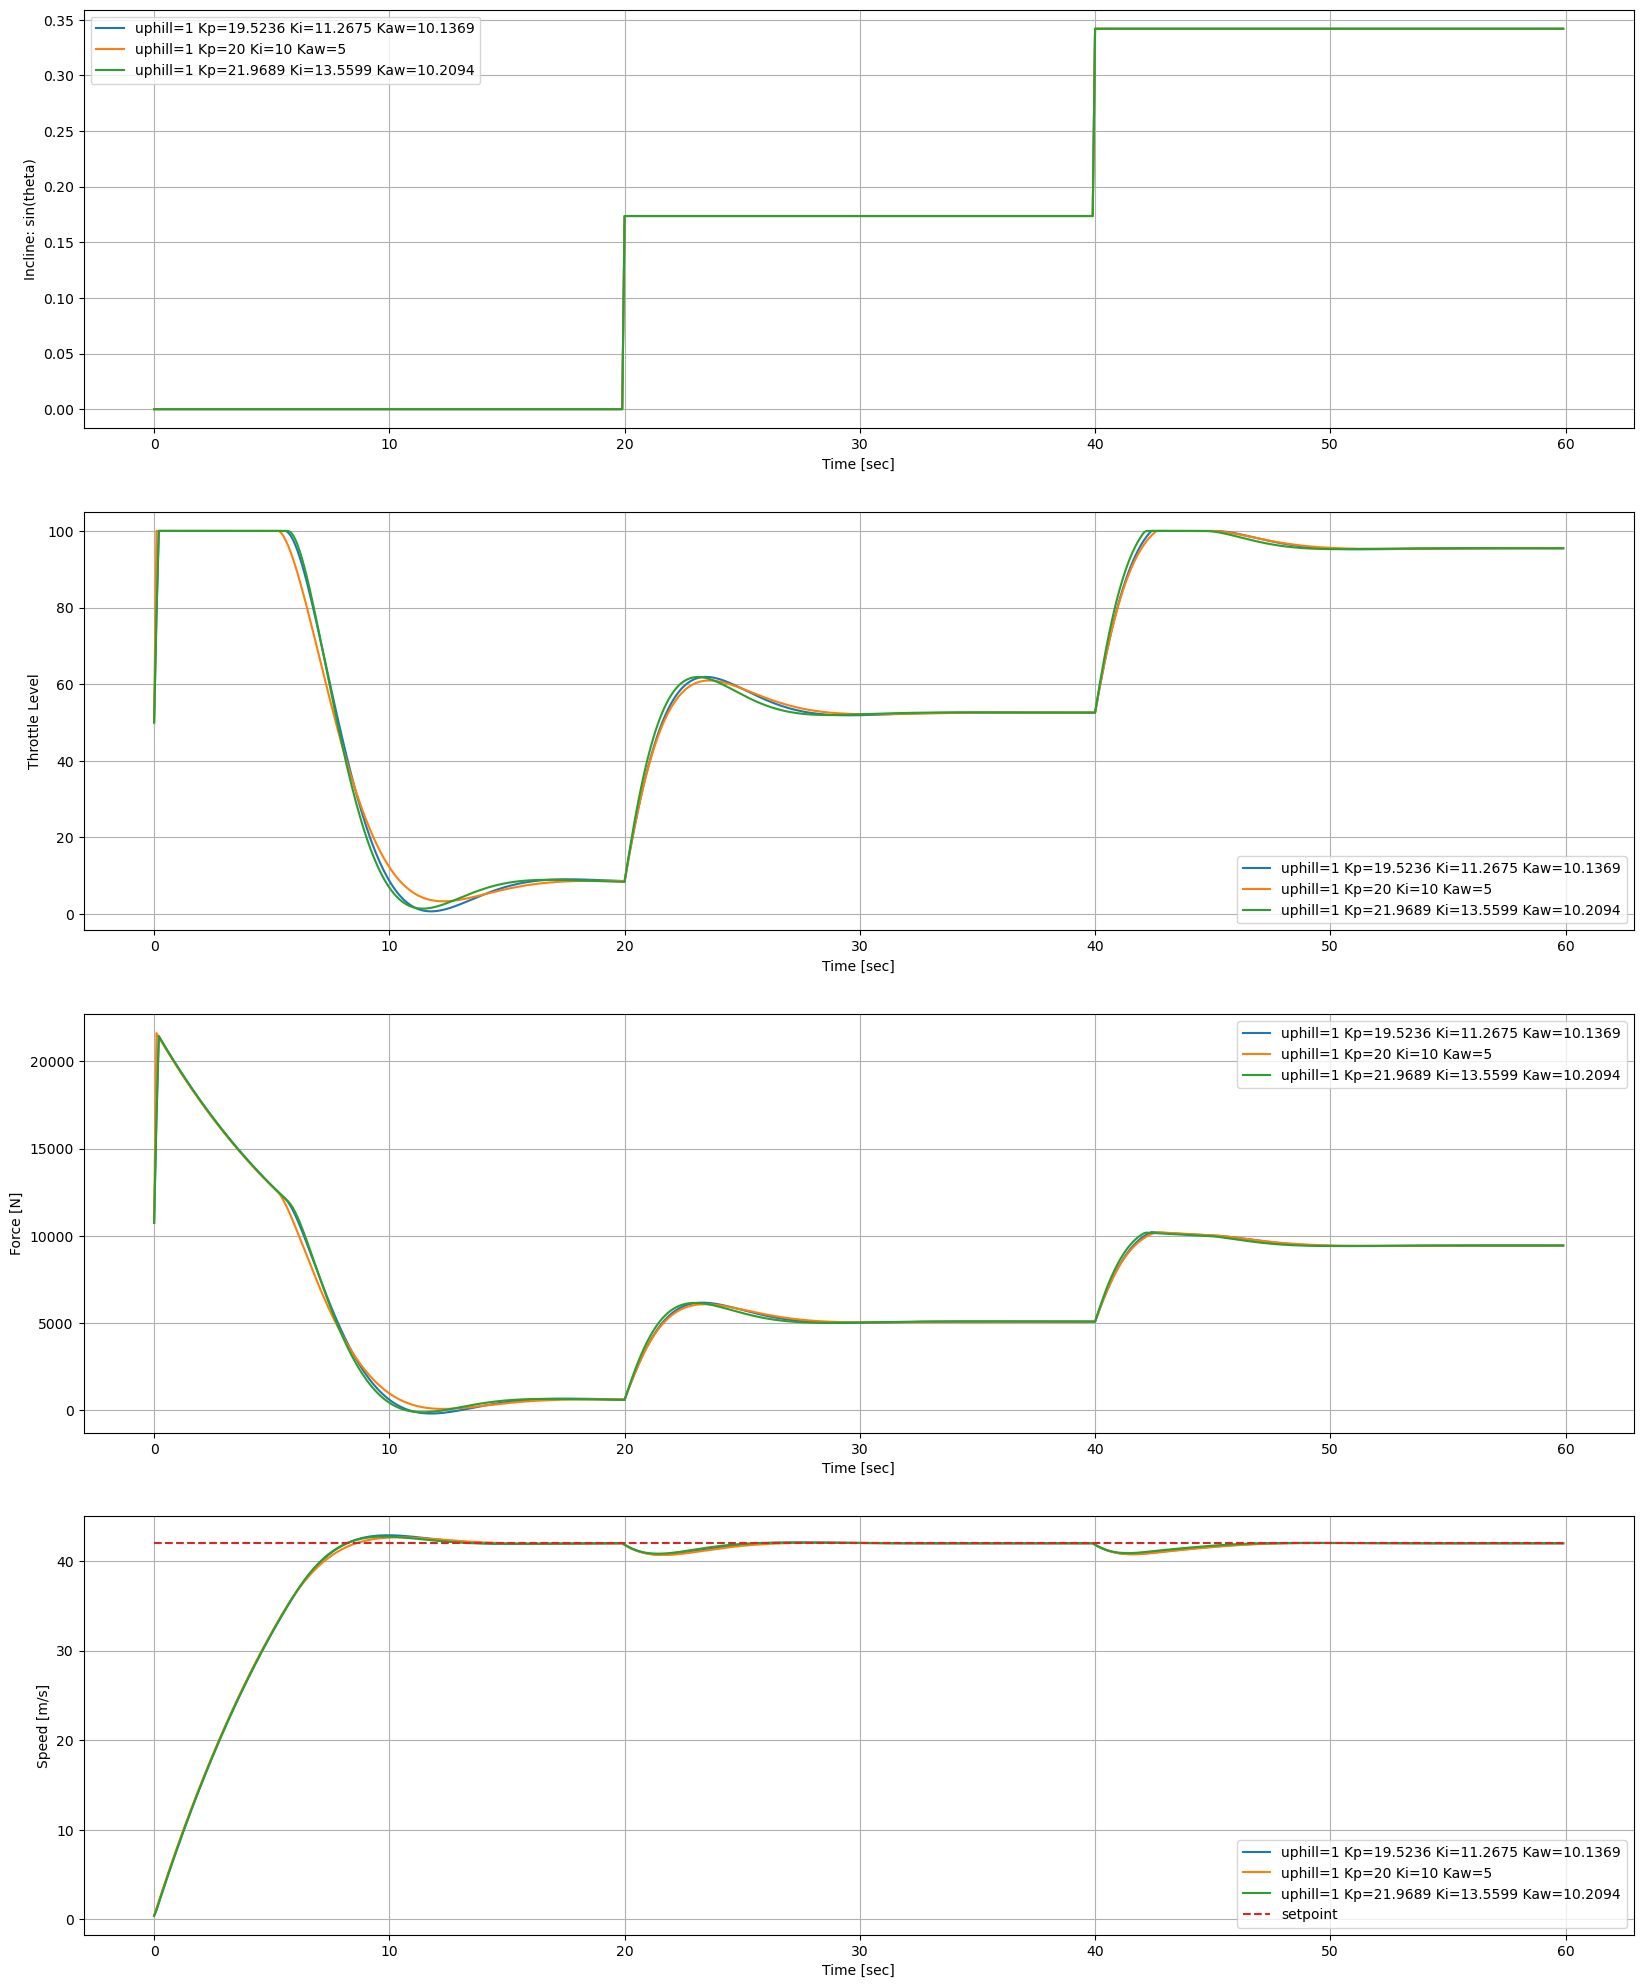

In [9]:
if __name__ == '__main__':
    Test().train().test()